# TMDB Data Investigation
## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
<li><a href="#limit">Limitations</a></li>    
</ul>

<a id='intro'></a>
## Introduction
> Using the [TMBD](https://www.themoviedb.org/) data we gonna try to investigate the properties associated with movies having high votes avg, high popularity, and high revenue.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import re
%matplotlib inline
pd.set_option('display.max_columns', None)

## Data wrangling
> To clean the data we gonna do the following
>> 1- Drop any cloumns that we wont need in our analysis.\
>> 2- Drop any dublicated rows.\
>> 3- Drop any row having NaN values.\
>> 4- Drop any row having a value of 0 in budget or revenue columns.\
>> 5- Drop any row having a value of vote count less than the lower quartile.

> We also gonna add a couple of useful columns
>> 1- A gross profit column, which is the difference between the revenue and the budget.\
>> 2- A length column, which separate the moves into 4 categories for runtime.

In [2]:
# loading the data set
df=pd.read_csv('tmdb-movies.csv')
df.head()

,id,imdb_id,popularity,budget,revenue,original_title,cast,homepage,director,tagline,keywords,overview,runtime,genres,production_companies,release_date,vote_count,vote_average,release_year,budget_adj,revenue_adj
0,135397,tt0369610,32.985763,150000000,1513528810,Jurassic World,Chris Pratt|Bryce Dallas Howard|Irrfan Khan|Vi...,http://www.jurassicworld.com/,Colin Trevorrow,The park is open.,monster|dna|tyrannosaurus rex|velociraptor|island,Twenty-two years after the events of Jurassic ...,124,Action|Adventure|Science Fiction|Thriller,Universal Studios|Amblin Entertainment|Legenda...,6/9/15,5562,6.5,2015,1.379999e+08,1.392446e+09
1,76341,tt1392190,28.419936,150000000,378436354,Mad Max: Fury Road,Tom Hardy|Charlize Theron|Hugh Keays-Byrne|Nic...,http://www.madmaxmovie.com/,George Miller,What a Lovely Day.,future|chase|post-apocalyptic|dystopia|australia,An apocalyptic story set in the furthest reach...,120,Action|Adventure|Science Fiction|Thriller,Village Roadshow Pictures|Kennedy Miller Produ...,5/13/15,6185,7.1,2015,1.379999e+08,3.481613e+08
2,262500,tt2908446,13.112507,110000000,295238201,Insurgent,Shailene Woodley|Theo James|Kate Winslet|Ansel...,http://www.thedivergentseries.movie/#insurgent,Robert Schwentke,One Choice Can Destroy You,based on novel|revolution|dystopia|sequel|dyst...,Beatrice Prior must confront her inner demons ...,119,Adventure|Science Fiction|Thriller,Summit Entertainment|Mandeville Films|Red Wago...,3/18/15,2480,6.3,2015,1.012000e+08,2.716190e+08
3,140607,tt2488496,11.173104,200000000,2068178225,Star Wars: The Force Awakens,Harrison Ford|Mark Hamill|Carrie Fisher|Adam D...,http://www.starwars.com/films/star-wars-episod...,J.J. Abrams,Every generation has a story.,android|spaceship|jedi|space opera|3d,Thirty years after defeating the Galactic Empi...,136,Action|Adventure|Science Fiction|Fantasy,Lucasfilm|Truenorth Productions|Bad Robot,12/15/15,5292,7.5,2015,1.839999e+08,1.902723e+09
4,168259,tt2820852,9.335014,190000000,1506249360,Furious 7,Vin Diesel|Paul Walker|Jason Statham|Michelle ...,http://www.furious7.com/,James Wan,Vengeance Hits Home,car race|speed|revenge|suspense|car,Deckard Shaw seeks revenge against Dominic Tor...,137,Action|Crime|Thriller,Universal Pictures|Original Film|Media Rights ...,4/1/15,2947,7.3,2015,1.747999e+08,1.385749e+09


### Data Cleaning

In [3]:
# We don't need 2 different id's, we will choose to work with "id" as the index and drop the "imdb_id"
# We will use the "budget_adj" and "revenue_adj" as they account for inflation over time, and will drop "budget" and "revenue"
# "homepage", "tagline", "overview", "keywords",and "production_companies" are not useful for our analysis so will drop them
# We only need the year of release, as we already have "release_year", we don't need "release_date"
df.drop(['imdb_id','budget','revenue','homepage','tagline','overview','release_date','keywords','production_companies'],axis=1,inplace=True)
df.set_index('id',inplace=True)
df.head()

,popularity,original_title,cast,director,runtime,genres,vote_count,vote_average,release_year,budget_adj,revenue_adj
id,,,,,,,,,,,
135397,32.985763,Jurassic World,Chris Pratt|Bryce Dallas Howard|Irrfan Khan|Vi...,Colin Trevorrow,124,Action|Adventure|Science Fiction|Thriller,5562,6.5,2015,1.379999e+08,1.392446e+09
76341,28.419936,Mad Max: Fury Road,Tom Hardy|Charlize Theron|Hugh Keays-Byrne|Nic...,George Miller,120,Action|Adventure|Science Fiction|Thriller,6185,7.1,2015,1.379999e+08,3.481613e+08
262500,13.112507,Insurgent,Shailene Woodley|Theo James|Kate Winslet|Ansel...,Robert Schwentke,119,Adventure|Science Fiction|Thriller,2480,6.3,2015,1.012000e+08,2.716190e+08
140607,11.173104,Star Wars: The Force Awakens,Harrison Ford|Mark Hamill|Carrie Fisher|Adam D...,J.J. Abrams,136,Action|Adventure|Science Fiction|Fantasy,5292,7.5,2015,1.839999e+08,1.902723e+09
168259,9.335014,Furious 7,Vin Diesel|Paul Walker|Jason Statham|Michelle ...,James Wan,137,Action|Crime|Thriller,2947,7.3,2015,1.747999e+08,1.385749e+09


In [4]:
# Check if there are any dup rows
df.duplicated().sum()

1

In [5]:
# Drop the dup rows
df.drop_duplicates(inplace=True)
df.duplicated().sum()

0

In [6]:
# Check if there any rows with 0 as the value of "budget_adj" or "revenue_adj"
df[df['budget_adj'] == 0].shape , df[df['revenue_adj'] == 0].shape

((5696, 11), (6016, 11))

In [7]:
# Drop any rows with 0 as the value of "budget_adj" or "revenue_adj"
df=df[df['budget_adj'] != 0]
df=df[df['revenue_adj'] != 0]
df[df['budget_adj'] == 0].shape , df[df['revenue_adj'] == 0].shape

((0, 11), (0, 11))

In [8]:
# Check that every column have the correct data type, and look for any null values 
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3854 entries, 135397 to 2161
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   popularity      3854 non-null   float64
 1   original_title  3854 non-null   object 
 2   cast            3850 non-null   object 
 3   director        3853 non-null   object 
 4   runtime         3854 non-null   int64  
 5   genres          3854 non-null   object 
 6   vote_count      3854 non-null   int64  
 7   vote_average    3854 non-null   float64
 8   release_year    3854 non-null   int64  
 9   budget_adj      3854 non-null   float64
 10  revenue_adj     3854 non-null   float64
dtypes: float64(4), int64(3), object(4)
memory usage: 361.3+ KB


In [9]:
# We can see that all column have the correct data type
# We drop any row having null value
df.dropna(inplace=True,axis=0)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3849 entries, 135397 to 2161
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   popularity      3849 non-null   float64
 1   original_title  3849 non-null   object 
 2   cast            3849 non-null   object 
 3   director        3849 non-null   object 
 4   runtime         3849 non-null   int64  
 5   genres          3849 non-null   object 
 6   vote_count      3849 non-null   int64  
 7   vote_average    3849 non-null   float64
 8   release_year    3849 non-null   int64  
 9   budget_adj      3849 non-null   float64
 10  revenue_adj     3849 non-null   float64
dtypes: float64(4), int64(3), object(4)
memory usage: 360.8+ KB


In [10]:
# Getting the value of the lower quartile.
df['vote_count'].describe()

count    3849.000000
mean      528.387114
std       880.333629
min        10.000000
25%        71.000000
50%       205.000000
75%       581.000000
max      9767.000000
Name: vote_count, dtype: float64

In [11]:
# Drop any row with "vote_count" value less than the lower quartile.
df=df[df['vote_count'] >= 71]
df.shape

(2892, 11)

### Adding Useful columns

In [12]:
# Adding "gross_profit" cloumn which capture the difference between "revenue_adj" and "budget_adj"
df['gross_profit']=df['revenue_adj']-df['budget_adj']
df.head()

,popularity,original_title,cast,director,runtime,genres,vote_count,vote_average,release_year,budget_adj,revenue_adj,gross_profit
id,,,,,,,,,,,,
135397,32.985763,Jurassic World,Chris Pratt|Bryce Dallas Howard|Irrfan Khan|Vi...,Colin Trevorrow,124,Action|Adventure|Science Fiction|Thriller,5562,6.5,2015,1.379999e+08,1.392446e+09,1.254446e+09
76341,28.419936,Mad Max: Fury Road,Tom Hardy|Charlize Theron|Hugh Keays-Byrne|Nic...,George Miller,120,Action|Adventure|Science Fiction|Thriller,6185,7.1,2015,1.379999e+08,3.481613e+08,2.101614e+08
262500,13.112507,Insurgent,Shailene Woodley|Theo James|Kate Winslet|Ansel...,Robert Schwentke,119,Adventure|Science Fiction|Thriller,2480,6.3,2015,1.012000e+08,2.716190e+08,1.704191e+08
140607,11.173104,Star Wars: The Force Awakens,Harrison Ford|Mark Hamill|Carrie Fisher|Adam D...,J.J. Abrams,136,Action|Adventure|Science Fiction|Fantasy,5292,7.5,2015,1.839999e+08,1.902723e+09,1.718723e+09
168259,9.335014,Furious 7,Vin Diesel|Paul Walker|Jason Statham|Michelle ...,James Wan,137,Action|Crime|Thriller,2947,7.3,2015,1.747999e+08,1.385749e+09,1.210949e+09


In [13]:
# Getting the values of max, Q1, Q2, Q3, min of "runtime" to use to group movies into 4 groups.
df['runtime'].describe()

count    2892.000000
mean      110.349585
std        19.540728
min        26.000000
25%        96.750000
50%       107.000000
75%       121.000000
max       216.000000
Name: runtime, dtype: float64

In [14]:
# Adding "length" column which sperate the movies into 4 groups wrt thier runtime.
bin_edges = [26, 96, 107, 121, 216]
bin_names = ['very short','short','long','very long' ]
df['length'] = pd.cut(df['runtime'],bin_edges, labels=bin_names)
df.head()

,popularity,original_title,cast,director,runtime,genres,vote_count,vote_average,release_year,budget_adj,revenue_adj,gross_profit,length
id,,,,,,,,,,,,,
135397,32.985763,Jurassic World,Chris Pratt|Bryce Dallas Howard|Irrfan Khan|Vi...,Colin Trevorrow,124,Action|Adventure|Science Fiction|Thriller,5562,6.5,2015,1.379999e+08,1.392446e+09,1.254446e+09,very long
76341,28.419936,Mad Max: Fury Road,Tom Hardy|Charlize Theron|Hugh Keays-Byrne|Nic...,George Miller,120,Action|Adventure|Science Fiction|Thriller,6185,7.1,2015,1.379999e+08,3.481613e+08,2.101614e+08,long
262500,13.112507,Insurgent,Shailene Woodley|Theo James|Kate Winslet|Ansel...,Robert Schwentke,119,Adventure|Science Fiction|Thriller,2480,6.3,2015,1.012000e+08,2.716190e+08,1.704191e+08,long
140607,11.173104,Star Wars: The Force Awakens,Harrison Ford|Mark Hamill|Carrie Fisher|Adam D...,J.J. Abrams,136,Action|Adventure|Science Fiction|Fantasy,5292,7.5,2015,1.839999e+08,1.902723e+09,1.718723e+09,very long
168259,9.335014,Furious 7,Vin Diesel|Paul Walker|Jason Statham|Michelle ...,James Wan,137,Action|Crime|Thriller,2947,7.3,2015,1.747999e+08,1.385749e+09,1.210949e+09,very long


In [15]:
# Saving the cleaned data
df.to_csv('TMDB_clean.csv')

<a id='eda'></a>
## Exploratory Data Analysis
> In an effort of investigate the properties associated with movies having high votes avg, high popularity, and high revenue, we will have some questions and will try to answer them using the data in hand.

#### Before we try to answer some question, first we want to see if things we know by intuition are really correct in this data set
> Do longer movies cost more?\
> Do better rated movies profits more?\
> Do better rated movies more popular?

We expect the answer to all of those question to be "yes", lets see if that is true

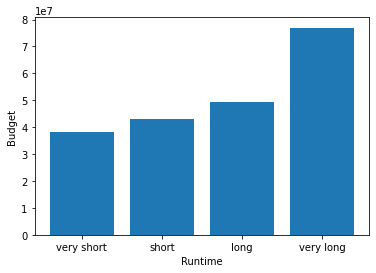

In [16]:
# Plotting the relation between "lenght" and "budget_adj"
plt.bar(df.groupby('length').mean()['budget_adj'].index,df.groupby('length').mean()['budget_adj'].values)
plt.title('')
plt.xlabel('Runtime')
plt.ylabel('Budget');

As expected, we can see that the longer the movie, the more it cost

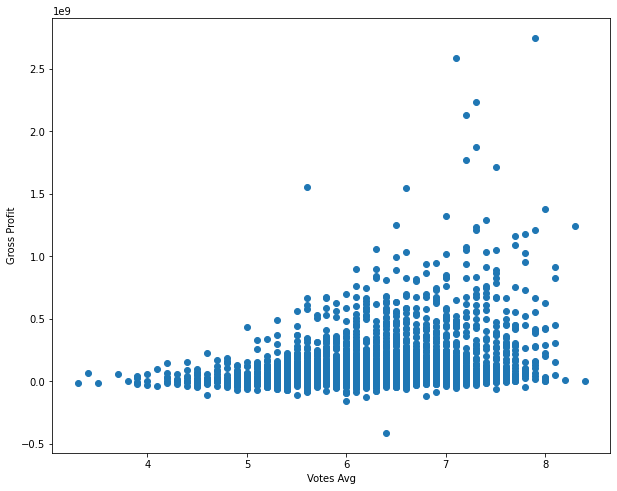

In [17]:
# Plotting the relation between "vote_average" and "gross_profit"
plt.figure(figsize=(10, 8))
plt.scatter(df['vote_average'],df['gross_profit'])
plt.title('')
plt.xlabel('Votes Avg')
plt.ylabel('Gross Profit');

Again, as expected, we can see that the movies with high rating score profit more.

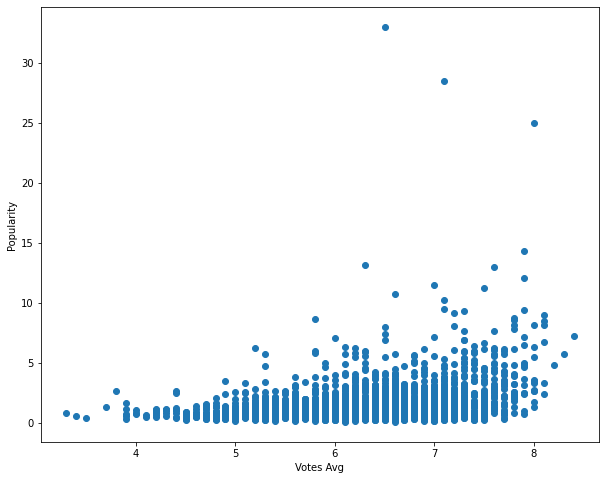

In [18]:
# Plotting the relation between "vote_average" and "popularity"
plt.figure(figsize=(10, 8))
plt.scatter(df['vote_average'],df['popularity'])
plt.title('')
plt.xlabel('Votes Avg')
plt.ylabel('Popularity');

Also , as expected, we can see that the movies with high rating score are more popular.

### Questions
<ul>
<li><a href="#Q1">How does movie budget affect its gross profit, votes avg, and popularity?</a></li>
<li><a href="#Q2">How does movie runtime affect its gross profit, votes avg, and popularity?</a></li>
<li><a href="#Q3">How does the length of movies change with time?</a></li>    
<li><a href="#Q4">Are movies becoming better/more profitable with time?</a></li>
</ul>

<a id='Q1'></a>
### How does budget affect gross profit, votes avg, and popularity?

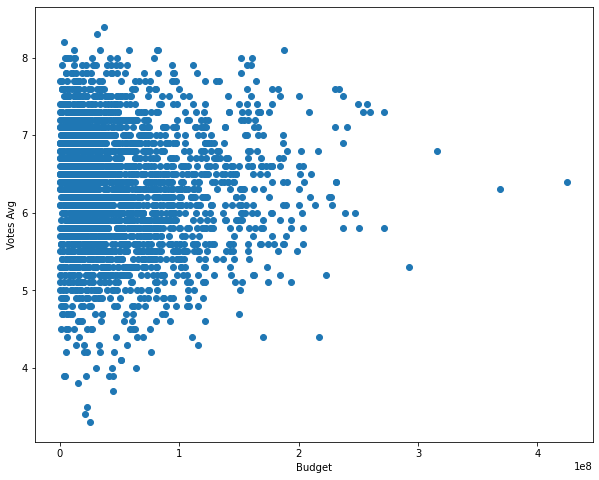

In [19]:
# Plotting the relation between "budget_adj" and "vote_average"
plt.figure(figsize=(10, 8))
plt.scatter(df['budget_adj'],df['vote_average'])
plt.title('')
plt.ylabel('Votes Avg')
plt.xlabel('Budget');

No corelation whatsoever between movie's budget and its votes avg. meaning, spending more on a movie doesn't guarantee that the audience will perceive it as a good movie

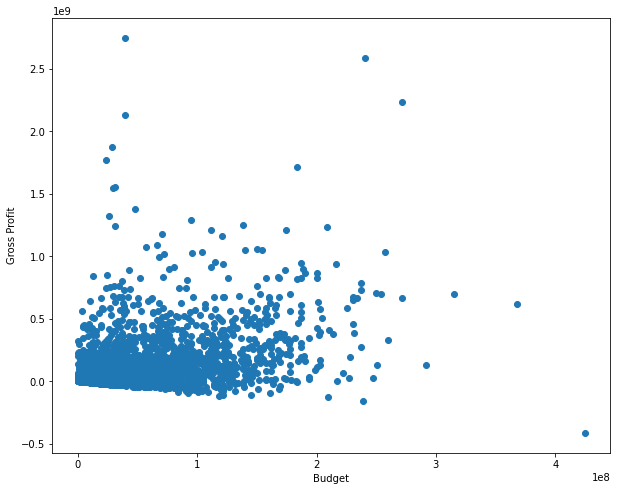

In [20]:
# Plotting the relation between "budget_adj" and "gross_profit"
plt.figure(figsize=(10, 8))
plt.scatter(df['budget_adj'],df['gross_profit'])
plt.title('')
plt.xlabel('Budget')
plt.ylabel('Gross Profit');

No corelation whatsoever between movie's budget and its gross profit, you can even see that the movie with the largest budget have a negative gross profit!

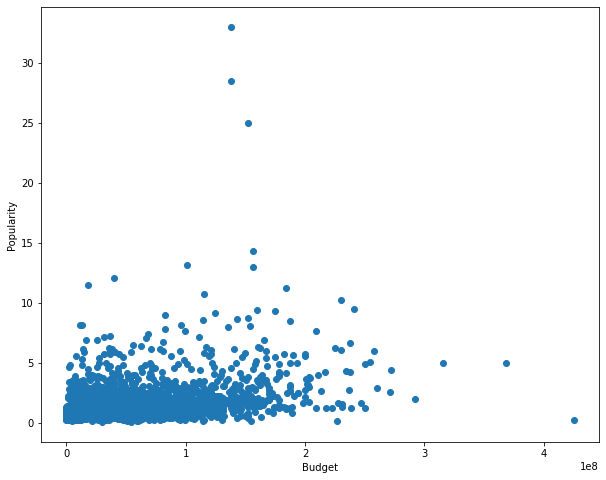

In [21]:
# Plotting the relation between "budget_adj" and "popularity"
plt.figure(figsize=(10, 8))
plt.scatter(df['budget_adj'],df['popularity'])
plt.title('')
plt.xlabel('Budget')
plt.ylabel('Popularity');

No corelation whatsoever between movie's budget and the its populartiy.

We can see that there is no corelation between the movie's budget and votes avg, gross profit, or popularity of the movie. **Movies with big budgets are not always successful movies.**


<a id='Q1'></a>
### How does movie runtime affect its gross profit, votes avg, and popularity?

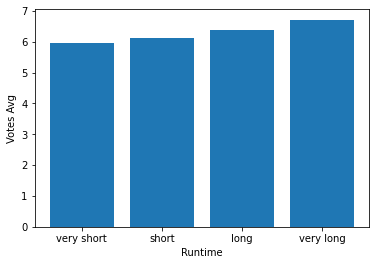

In [22]:
# Plotting the relation between "length" and "vote_average" means.
plt.bar(df.groupby('length').mean()['vote_average'].index,df.groupby('length').mean()['vote_average'].values)
plt.title('')
plt.xlabel('Runtime')
plt.ylabel('Votes Avg');

We can see that the longer the movies the better score on average it gets. this is more visable in the line plot below.

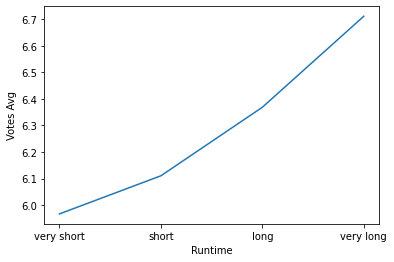

In [23]:
# Plotting the relation between "length" and "vote_average" means.
plt.plot(df.groupby('length').mean()['vote_average'].index,df.groupby('length').mean()['vote_average'].values)
plt.title('')
plt.xlabel('Runtime')
plt.ylabel('Votes Avg');

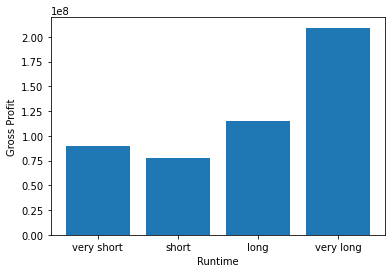

In [24]:
# Plotting the relation between "length" and "gross_profit" means.
plt.bar(df.groupby('length').mean()['gross_profit'].index,df.groupby('length').mean()['gross_profit'].values)
plt.title('')
plt.xlabel('Runtime')
plt.ylabel('Gross Profit');

We can see that the longer the movie, the more profitable it is, this is not surprising as we know that longer movies have a better rating on average, and better rated movies are more profitable.

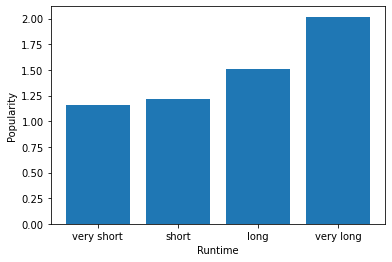

In [25]:
# Plotting the relation between "length" and "popularity" means.
plt.bar(df.groupby('length').mean()['popularity'].index,df.groupby('length').mean()['popularity'].values)
plt.title('')
plt.xlabel('Runtime')
plt.ylabel('Popularity');

Same as previous, we know that longer movies have a better rating on average, and better rated movies are more popular. so again this is to be expected

From the previous analysis one can see that **successful movies tend to be long**

<a id='Q3'></a>
### How does the length of movies change with time?

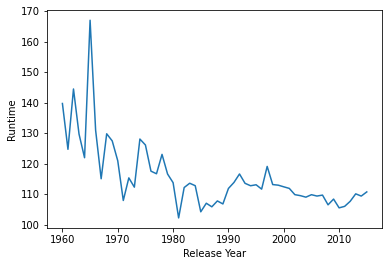

In [26]:
# Plotting the relation between "release_year" and "runtime" means.
plt.plot(df.groupby('release_year').mean()['runtime'].index,df.groupby('release_year').mean()['runtime'].values)
plt.title('')
plt.xlabel('Release Year')
plt.ylabel('Runtime');

We can see that the values before year "1980" is oscillating very violently, One can assume that because there is no enough data for this period, the data is dominated by outliers.\
lets check if that is true

In [27]:
df[df['release_year']<1980].shape, df.shape

((127, 13), (2892, 13))

We can see that only 127 movie out of 2892 (4.4%) in the data are released before 1980, so due to lake of data and to get meaning full statistics one will only consider movies released at 1980 onward.

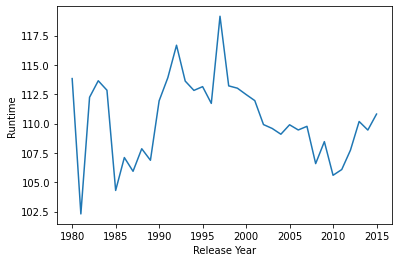

In [28]:
plt.plot(df[df['release_year']>=1980].groupby('release_year').mean()['runtime'].index,df[df['release_year']>=1980].groupby('release_year').mean()['runtime'].values,)
plt.title('')
plt.xlabel('Release Year')
plt.ylabel('Runtime');

It's clear that thier is **no coralation** between movies length and when were they released.

<a id='Q4'></a>
### Are movies becoming better/more profitable with time?

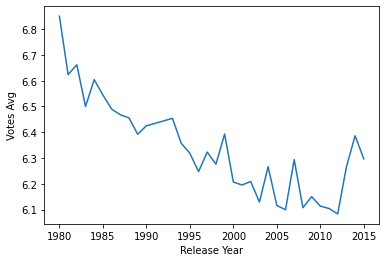

In [29]:
# Plotting the relation between "release_year" and "vote_average" means.
plt.plot(df[df['release_year']>=1980].groupby('release_year').mean()['vote_average'].index,df[df['release_year']>=1980].groupby('release_year').mean()['vote_average'].values)
plt.title('')
plt.xlabel('Release Year')
plt.ylabel('Votes Avg');

It's clear that movies are getting lower and lower scores on average with time! 

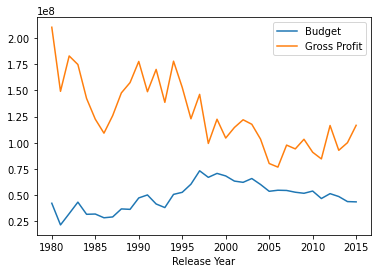

In [30]:
# Plotting the relation between "release_year" and "budget_adj"/"gross_profit" means.
plt.plot(df[df['release_year']>=1980].groupby('release_year').mean()['budget_adj'].index,df[df['release_year']>=1980].groupby('release_year').mean()['budget_adj'].values, label='Budget')
plt.plot(df[df['release_year']>=1980].groupby('release_year').mean()['gross_profit'].index,df[df['release_year']>=1980].groupby('release_year').mean()['gross_profit'].values, label='Gross Profit')
plt.title('')
plt.xlabel('Release Year')
plt.ylabel('')
plt.legend();

We can see that despite the noticable grow in movie's budgets with time, the average profite per year is going down.\
This may be because as we saw ealier, movies ratting is going down with time, but also this can be credited to the spreading of internet and pirated movies.

# Top 100
Here we will take a closer look on the top 100 movies with the highest votes avg score. and We will try to answer two questions.
> <a href="#Q1_100">Which genre have the largest presence in top 100?</a>\
> <a href="#Q2_100">How popular each genre is?</a>, also we will try to answer the ultimate question:\
> <a href="#Q3_100">Who is the greatest director of all time?</a>, spoiler alert, it's Christopher Nolan.

In [31]:
# We will select the 100 movies with the highest "vote_average".
# If there is a tie between multible movies at the end wit hthe same ratting, will select the movies with higher "vote_count".
df_100=df.sort_values(by=['vote_average','vote_count'],ascending=False).iloc[0:100]
df_100.head()

,popularity,original_title,cast,director,runtime,genres,vote_count,vote_average,release_year,budget_adj,revenue_adj,gross_profit,length
id,,,,,,,,,,,,,
278,7.192039,The Shawshank Redemption,Tim Robbins|Morgan Freeman|Bob Gunton|William ...,Frank Darabont,142,Drama|Crime,5754,8.4,1994,3.677779e+07,4.169346e+07,4.915674e+06,very long
238,5.738034,The Godfather,Marlon Brando|Al Pacino|James Caan|Richard S. ...,Francis Ford Coppola,175,Drama|Crime,3970,8.3,1972,3.128737e+07,1.277914e+09,1.246626e+09,very long
244786,4.780419,Whiplash,Miles Teller|J.K. Simmons|Melissa Benoist|Aust...,Damien Chazelle,105,Drama|Music,2372,8.2,2014,3.039600e+06,1.288891e+07,9.849312e+06,short
155,8.466668,The Dark Knight,Christian Bale|Michael Caine|Heath Ledger|Aaro...,Christopher Nolan,152,Drama|Action|Crime|Thriller,8432,8.1,2008,1.873655e+08,1.014733e+09,8.273675e+08,very long
550,8.947905,Fight Club,Edward Norton|Brad Pitt|Meat Loaf|Jared Leto|H...,David Fincher,139,Drama,5923,8.1,1999,8.247033e+07,1.320229e+08,4.955256e+07,very long


A lot of movies have two or more genres, to fix this we will separate the row with multible genres to multible rows each with one genre

In [32]:
# In fact I'll create a function that do that for any column in any dataframe. It could be useful in the future.
def sperate_values(df_in,column):
    df=df_in.copy()
    df_list=[]
    multi=df[df[column].str.contains('\|')]
    for i in multi.index:
        things=multi.loc[i,column].split('|')
        df.drop(i,axis=0,inplace=True)
        for thing in things:
            multi.loc[i,column]=thing
            new=multi.loc[[i]]
            df_list.append(new)
    df_list.append(df)
    df=pd.concat(df_list,axis=0)
    return df

In [33]:
df_genres=sperate_values(df_100,'genres')
df_genres.head()

,popularity,original_title,cast,director,runtime,genres,vote_count,vote_average,release_year,budget_adj,revenue_adj,gross_profit,length
id,,,,,,,,,,,,,
278,7.192039,The Shawshank Redemption,Tim Robbins|Morgan Freeman|Bob Gunton|William ...,Frank Darabont,142,Drama,5754,8.4,1994,3.677779e+07,4.169346e+07,4.915674e+06,very long
278,7.192039,The Shawshank Redemption,Tim Robbins|Morgan Freeman|Bob Gunton|William ...,Frank Darabont,142,Crime,5754,8.4,1994,3.677779e+07,4.169346e+07,4.915674e+06,very long
238,5.738034,The Godfather,Marlon Brando|Al Pacino|James Caan|Richard S. ...,Francis Ford Coppola,175,Drama,3970,8.3,1972,3.128737e+07,1.277914e+09,1.246626e+09,very long
238,5.738034,The Godfather,Marlon Brando|Al Pacino|James Caan|Richard S. ...,Francis Ford Coppola,175,Crime,3970,8.3,1972,3.128737e+07,1.277914e+09,1.246626e+09,very long
244786,4.780419,Whiplash,Miles Teller|J.K. Simmons|Melissa Benoist|Aust...,Damien Chazelle,105,Drama,2372,8.2,2014,3.039600e+06,1.288891e+07,9.849312e+06,short


<a id='Q1_100'></a>
### Which genre have the largest presence in top 100?
let's look at the distribution of genres in the top 100 movies

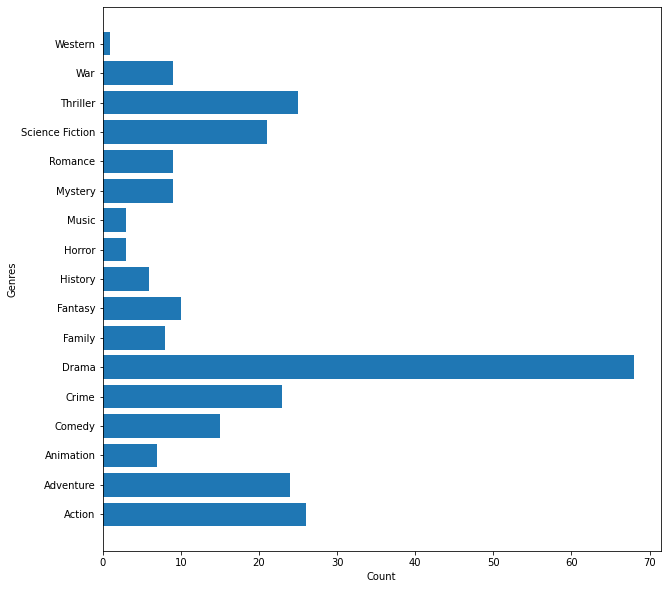

In [34]:
# Plotting the relation between "genres" and "genre_count".
plt.figure(figsize=(10, 10))
plt.barh(df_genres.groupby('genres').count().index,df_genres.groupby('genres').count()['vote_average'].values)
plt.title('')
plt.xlabel('Count')
plt.ylabel('Genres');

We can see that "Drama" is the most presnet genre in the top 100 with a huge margin, one can assume that this is just because most of the movies are drama movies, so no wonder that the most presnet genre in the top 100 movies is "Drama"\
Lets test that.

In [35]:
df[df['genres'].str.contains('Drama')].shape,df.shape

((1227, 13), (2892, 13))

In [36]:
df_100[df_100['genres'].str.contains('Drama')].shape,df_100.shape

((68, 13), (100, 13))

We can see that only 1227 out of 2892 movies are drama movies, (42.4%), while 68 out of the top 100 movies (68%) are drama movies.\
So we conclude that the huge presence of drama movies in the top 100 is not just a manifestation of its abundancy.

<a id='Q2_100'></a>
### How popular each genre is?
Let's take a look at the average popualrity of each genre in the top 100 movies

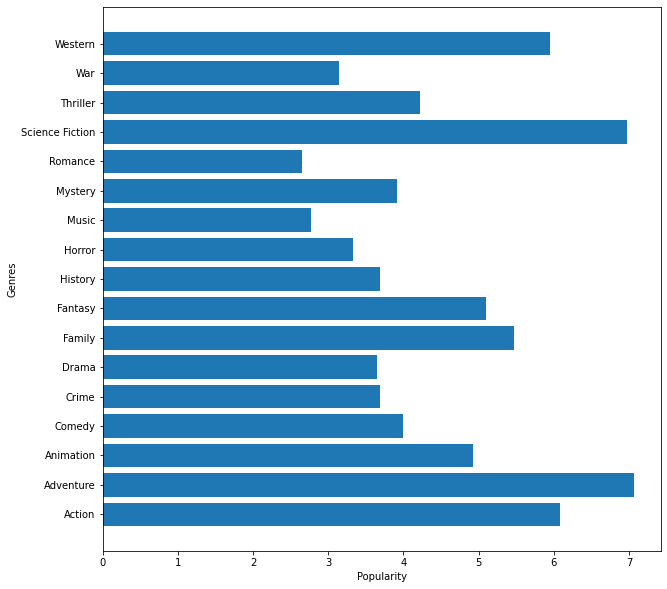

In [37]:
# Plotting the relation between "genres" and "popularity" means.
plt.figure(figsize=(10, 10))
plt.barh(df_genres.groupby('genres').mean().index,df_genres.groupby('genres').mean()['popularity'].values)
plt.title('')
plt.xlabel('Popularity')
plt.ylabel('Genres');

We can see that the most popular genres are Adventure and Sci-Fi, with Action and Western as a close second, and Family as third.\
This also shows a lot of very interesting and non trivial results,
> 1- despite having the lower presence in the top 100, western are very popular.\
> 2- Animation movies is alos very popular despite the low presence in the top 100.\
> 3- Drama movies having average popularity despite being the most present genre in the top 100.

This is very visable in the next graph

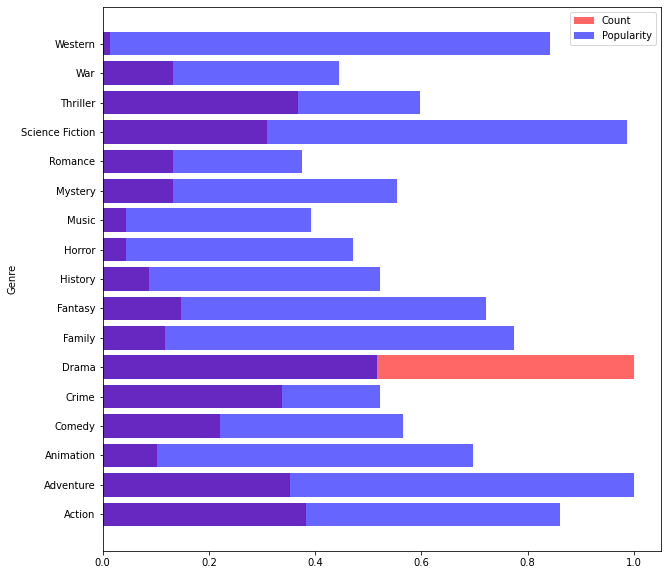

In [38]:
# Plotting the relation between "genres" and "genre_count"/"popularity" rescaled such that the hight of the maximum bar is one.
plt.figure(figsize=(10, 10))
plt.barh(df_genres.groupby('genres').count().index,df_genres.groupby('genres').count()['vote_count'].values/df_genres.groupby('genres').count()['vote_count'].values.max(),color='r',alpha=0.6,label='Count')
plt.barh(df_genres.groupby('genres').mean().index,df_genres.groupby('genres').mean()['popularity'].values/df_genres.groupby('genres').mean()['popularity'].values.max(),color='b',alpha=0.6,label='Popularity')
plt.title('')
plt.xlabel('')
plt.ylabel('Genre')
plt.legend();

<a id='Q3_100'></a>
### Who is the greatest director of all time?

One good measure is to see how many movies directed by the same director is in the top 100.\
Again we see that some movies have two or more directors, we will use the already defined function to separate them.

In [39]:
df_directors=sperate_values(df_100,'director')
df_directors.shape

(106, 13)

We will take a look at the count of movies directed by each director in the top 100, ignoring directors with only one movie in the top 100

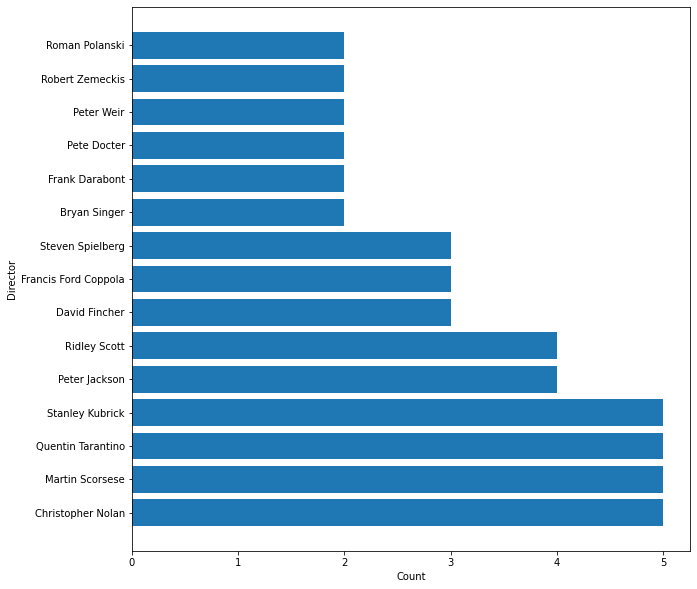

In [40]:
# Plotting the relation between "director" and "director_count".
df_drt=df_directors.groupby('director').count()
df_drt=df_drt[df_drt['vote_average']>1]
df_drt=df_drt.sort_values(by='popularity',ascending=False)
plt.figure(figsize=(10, 10))
plt.barh(df_drt.index,df_drt['vote_count'].values)
plt.title('')
plt.ylabel('Director')
plt.xlabel('Count');

We can see that four directors (Christopher Nolan, Martin Scorsese, Stanley Kubrick, Quentin Tarantino) are tied with each have 5 movies in top 100.\
There must be only one "Greatest Director of All Time", so we will need to do some more work.\
First thing we can do is to see the precentage of each directors movies that is in top 100

In [41]:
candidates=['Christopher Nolan', 'Martin Scorsese', 'Stanley Kubrick', 'Quentin Tarantino']
for candidate in candidates:
    all_count=df['director'].str.contains(candidate).sum()
    top100_count=df_directors['director'].str.contains(candidate).sum()
    print(f'{candidate} have {top100_count} movies in the top 100 out of total {all_count} he directed with a precentage = {top100_count/all_count*100}%')

Christopher Nolan have 5 movies in the top 100 out of total 8 he directed with a precentage = 62.5%
Martin Scorsese have 5 movies in the top 100 out of total 16 he directed with a precentage = 31.25%
Stanley Kubrick have 5 movies in the top 100 out of total 8 he directed with a precentage = 62.5%
Quentin Tarantino have 5 movies in the top 100 out of total 12 he directed with a precentage = 41.66666666666667%


We reduced the candidates to only two candidates (Christopher Nolan and Stanley Kubrick). We can compare between the mean score and the mean popularity of thier movies to see who will get the title.

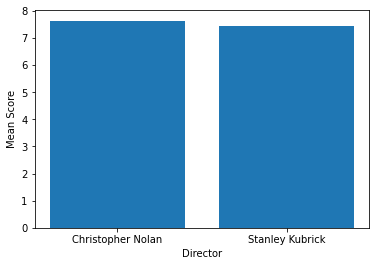

In [42]:
plt.bar(['Christopher Nolan','Stanley Kubrick'],[df[df['director'] == 'Christopher Nolan']['vote_average'].mean(),df[df['director'] == 'Stanley Kubrick']['vote_average'].mean()])
plt.title('')
plt.ylabel('Mean Score')
plt.xlabel('Director');

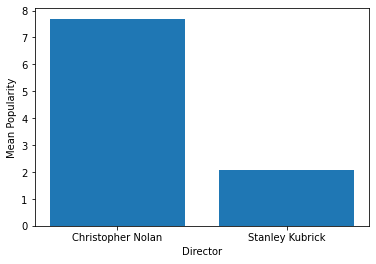

In [43]:
plt.bar(['Christopher Nolan','Stanley Kubrick'],[df[df['director'] == 'Christopher Nolan']['popularity'].mean(),df[df['director'] == 'Stanley Kubrick']['popularity'].mean()])
plt.title('')
plt.ylabel('Mean Popularity')
plt.xlabel('Director');

We can see that Nolan wins in both cases, The difference in thier movies score is very slim, but the difference in the popularity of thier movies is very huge.

<a id='conclusions'></a>
## Conclusions
<ul>
<li>There is no corelation between the movie's budget and votes avg, gross profit, or popularity of the movie. Movies with big budgets are not always successful movies.</li>
<li>Successful movies tend to be long.</li>
<li>Thier is no coralation between movies length and when were they released.</li>
<li>Movies are getting lower and lower scores on average with time!</li>
<li>Despite the noticable grow in movie's budgets with time, the average profite per year is going down.</li>
<li>The genre with the larges presence in the top 100 movies is "Drama", and that huge presence is not just a manifestation of its abundancy.</li> 
<li>The most popular genres are Adventure and Sci-Fi, with Action and Western as a close second, and Family as third.</li>
<li>Western and Animation movies are very popular but have low presence in the top 100.</li>
<li>Drama movies have average popularity despite being the most present genre in the top 100.</li>
<li>Christopher Nolan is the greatest director of all time.</li> 
</ul>


<a id='limit'></a>
## Limitation
The only limitation to this analysis is the lack of data for movies released before 1980, as we saw earlier there is only 127 entries, this makes the analysis for this era a kind of impossible as an outlier will render the analysis faulty